In [ ]:
# Importing necessary libraries
import zipfile
import os
import torch
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import time
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
import torch.nn as nn

In [ ]:
# Zip Extraction
zip_file_path = 'cnn_dataset.zip'
extracted_dir_path = os.path.join(os.path.dirname(zip_file_path), 'cnn_dataset')
os.makedirs(extracted_dir_path, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir_path)
print("Extraction complete.")

Extraction complete.


# Base Case + Regularization + Dropout + Early Stooping + Image augmentation

## Data Preprocessing

In [ ]:
# Transformations
image_transformation = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

image_dataset = datasets.ImageFolder(root='cnn_dataset', transform=image_transformation)

In [ ]:
# Dataset Information
print("Number of images available: ", len(image_dataset))
num_classes = len(image_dataset.classes)
print("Number of classes: ", num_classes)

class_distribution = {}
for _, label in image_dataset:
    class_distribution[label] = class_distribution.get(label, 0) + 1
print("Class distribution:", class_distribution)

Number of images available:  30000
Number of classes:  3
Class distribution: {0: 10000, 1: 10000, 2: 10000}


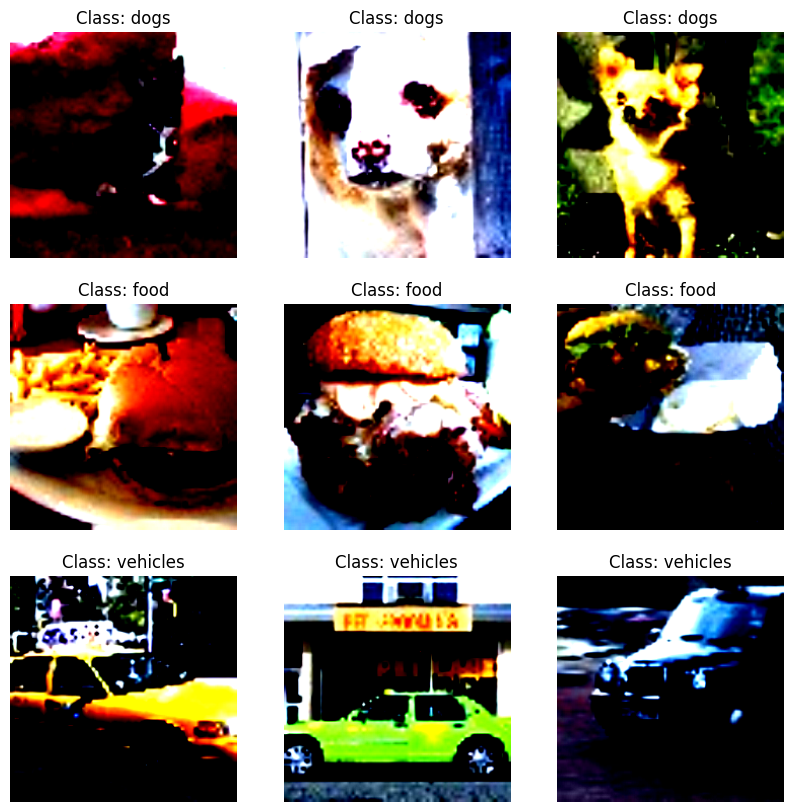

In [ ]:
# Visualization 1(Sample Images)
def show_images(image_dataset, num_samples_per_class=3):
    plt.figure(figsize=(10, 10))
    classes = image_dataset.classes
    for i, class_name in enumerate(classes):
        class_indices = [idx for idx, (_, label) in enumerate(image_dataset) if label == i]
        sampled_indices = class_indices[:num_samples_per_class]
        for j, idx in enumerate(sampled_indices):
            image, _ = image_dataset[idx]
            plt.subplot(num_classes, num_samples_per_class, i * num_samples_per_class + j + 1)
            plt.title(f"Class: {class_name}")
            plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
            plt.axis('off')
    plt.show()

show_images(image_dataset)

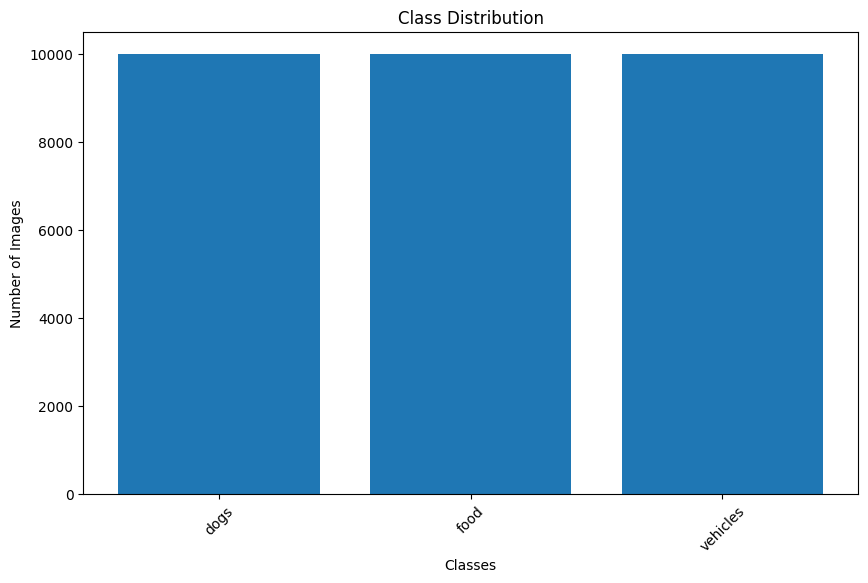

In [ ]:
# Visualization 2(Class Distribution Bar Chart)
plt.figure(figsize=(10, 6))
class_names = image_dataset.classes
class_counts = [class_distribution[i] for i in range(num_classes)]
plt.bar(class_names, class_counts)
plt.title('Class Distribution')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()

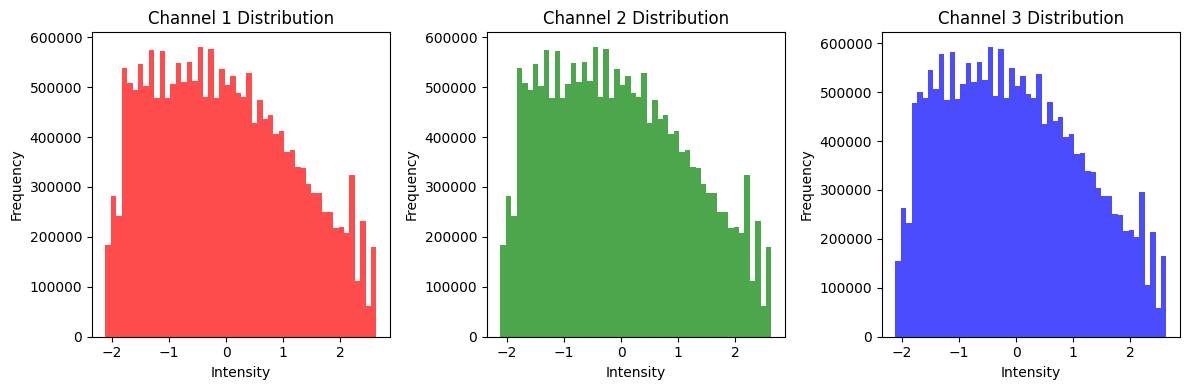

In [ ]:
# Visualization 3(RGB Channel Distribution)
plt.figure(figsize=(12, 4))
for i in range(3):
    plt.subplot(1, 3, i+1)
    channel_values = [image[:, :, i].numpy().ravel() for image, _ in image_dataset]
    plt.hist(np.concatenate(channel_values), bins=50, color=['r', 'g', 'b'][i], alpha=0.7)
    plt.title(f'Channel {i+1} Distribution')
    plt.xlabel('Intensity')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
# Convert targets to categorical values
image_dataset.targets = torch.tensor(image_dataset.targets)

In [ ]:
# Split dataset
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

train_size = int(train_ratio * len(image_dataset))
val_size = int(val_ratio * len(image_dataset))
test_size = len(image_dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(image_dataset, [train_size, val_size, test_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Print sizes of each dataset
print("Size of training dataset:", len(train_dataset))
print("Size of validation dataset:", len(val_dataset))
print("Size of testing dataset:", len(test_dataset))

# Class
class_counts = {class_name: 0 for class_name in train_dataset.dataset.classes}
for _, label in train_dataset:
    class_counts[train_dataset.dataset.classes[label]] += 1
print("\nClass-wise size of training dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

class_counts = {class_name: 0 for class_name in val_dataset.dataset.classes}
for _, label in val_dataset:
    class_counts[val_dataset.dataset.classes[label]] += 1
print("\nClass-wise size of validation dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

class_counts = {class_name: 0 for class_name in test_dataset.dataset.classes}
for _, label in test_dataset:
    class_counts[test_dataset.dataset.classes[label]] += 1
print("\nClass-wise size of testing dataset:")
for class_name, count in class_counts.items():
    print(f"{class_name}: {count}")

Size of training dataset: 21000
Size of validation dataset: 4500
Size of testing dataset: 4500

Class-wise size of training dataset:
dogs: 6978
food: 7010
vehicles: 7012

Class-wise size of validation dataset:
dogs: 1500
food: 1542
vehicles: 1458

Class-wise size of testing dataset:
dogs: 1522
food: 1448
vehicles: 1530


## VGG13 Architecture

In [ ]:
# VGG13 Architecture
class VGG13(nn.Module):
    def __init__(self, num_classes=3):
        super(VGG13, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 1000),
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

model = VGG13(num_classes)
print(model)

VGG13(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (15): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (16)

In [ ]:
# Data augmentation
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
train_dataset.dataset.transform = train_transform

In [ ]:
# Define Regularization(optimizer), loss function, and scheduler
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.3, verbose=True)

In [ ]:
# Train the model
from torch.nn.parallel import DataParallel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Wrap the model with DataParallel if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    model = DataParallel(model)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
num_epochs = 10
best_val_loss = float('inf')
patience = 0

start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        current_time = time.time()
        if current_time - start_time >= 50:
            print(f"Epoch {epoch + 1}/{num_epochs}, "
                  f"Total images trained: {total_train}, "
                  f"Training Accuracy: {100 * correct_train / total_train:.2f}%")
            start_time = current_time

    train_loss /= len(train_loader.dataset)
    train_accuracy = correct_train / total_train

    # Validation of model
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_accuracy = correct_val / total_val

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Training Loss: {train_loss:.4f}, '
          f'Training Accuracy: {100 * train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, '
          f'Validation Accuracy: {100 * val_accuracy:.2f}%')

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience = 0
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience += 1
        if patience > 5:
            print("Early stopping.")
            break

    scheduler.step(val_loss)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

Epoch 1/10, Total images trained: 3552, Training Accuracy: 34.04%
Epoch 1/10, Total images trained: 7168, Training Accuracy: 38.91%
Epoch 1/10, Total images trained: 10656, Training Accuracy: 45.92%
Epoch 1/10, Total images trained: 14208, Training Accuracy: 49.69%
Epoch 1/10, Total images trained: 17760, Training Accuracy: 52.82%
Epoch 1/10, Training Loss: 1.2245, Training Accuracy: 55.37%, Validation Loss: 0.6935, Validation Accuracy: 69.89%
Epoch 2/10, Total images trained: 32, Training Accuracy: 93.75%
Epoch 2/10, Total images trained: 3584, Training Accuracy: 72.66%
Epoch 2/10, Total images trained: 7136, Training Accuracy: 73.82%
Epoch 2/10, Total images trained: 10688, Training Accuracy: 74.59%
Epoch 2/10, Total images trained: 14240, Training Accuracy: 74.66%
Epoch 2/10, Total images trained: 17792, Training Accuracy: 74.83%
Epoch 2/10, Training Loss: 0.6291, Training Accuracy: 75.00%, Validation Loss: 0.5434, Validation Accuracy: 78.78%
Epoch 3/10, Total images trained: 32, Tr

In [ ]:
# Load
model.load_state_dict(torch.load('best_model.pth'))

<All keys matched successfully>

## Results

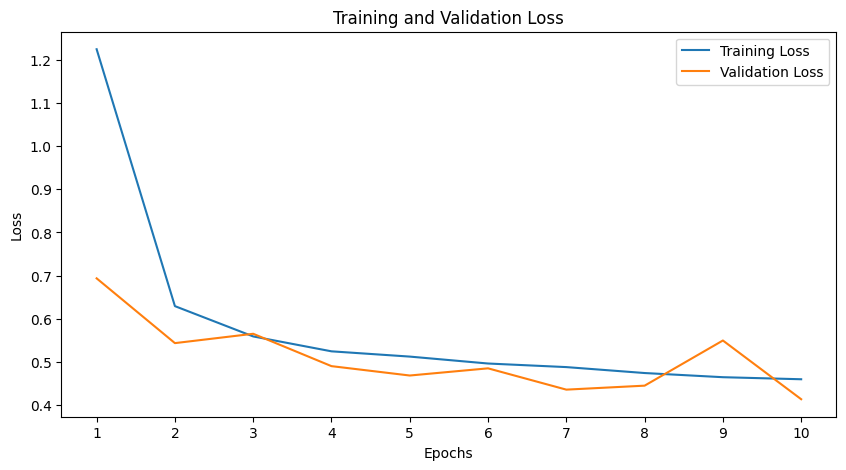

In [ ]:
# Plot training and validation loss
plt.figure(figsize=(10, 5))
epochs = range(1, len(train_losses) + 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.xticks(epochs)
plt.show()

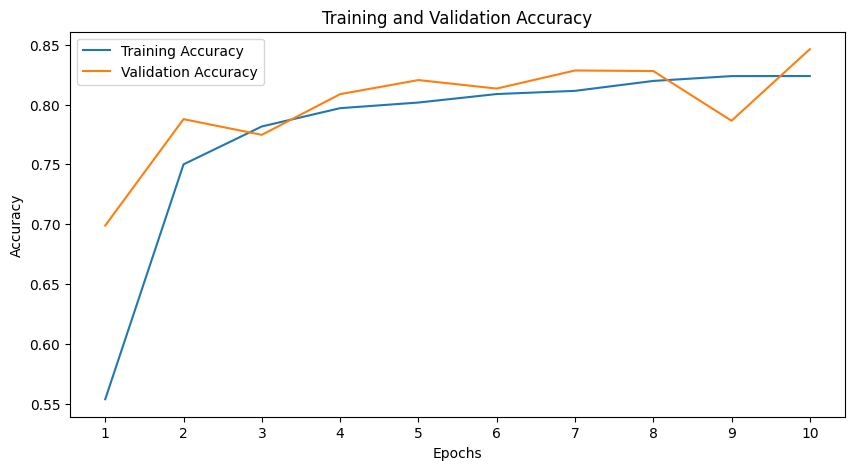

In [ ]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.xticks(epochs)
plt.show()

In [ ]:
# Testing loop
correct_test = 0
total_test = 0
test_loss = 0.0
model.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total_test += labels.size(0)
        correct_test += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)

test_loss /= len(test_loader.dataset)
test_accuracy = correct_test / total_test
print(f'Test Accuracy: {100 * test_accuracy:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

Test Accuracy: 83.42%
Test Loss: 0.4281


In [ ]:
# Confusion matrix  
# Precision, recall, and F1 score
true_labels = []
predicted_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.cpu().numpy()) 
        predicted_labels.extend(predicted.cpu().numpy()) 

conf_matrix = confusion_matrix(true_labels, predicted_labels)

precision, recall, f1_score, _ = precision_recall_fscore_support(true_labels, predicted_labels, average='weighted')
print("Confusion Matrix:")
print(conf_matrix)

print("\nEvaluation Metrics:")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1_score:.4f}")

Confusion Matrix:
[[1196  187  139]
 [ 180 1192   76]
 [ 123   55 1352]]

Evaluation Metrics:
Precision: 0.8307
Recall: 0.8311
F1 Score: 0.8308
